In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

In [3]:
df = pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


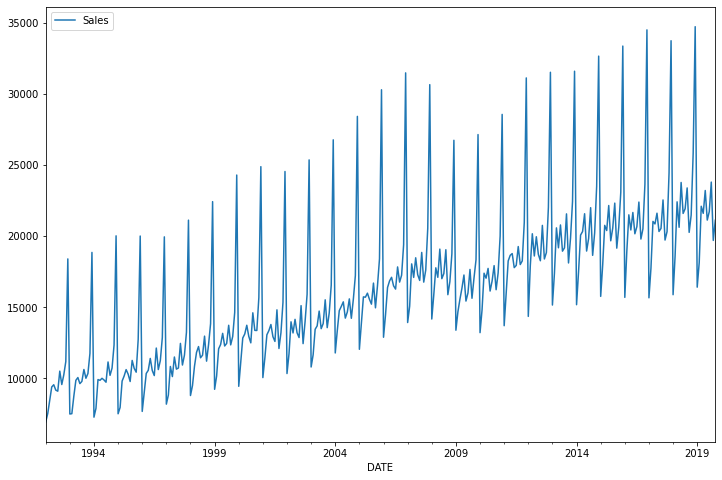

In [4]:
df.columns = ['Sales']
df.plot(figsize=(12,8))

In [6]:
print(len(df),len(df)-18)
test_size = 18
test_ind = len(df)- test_size
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

334 316


In [9]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [10]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [11]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
X,y = generator[0]

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [13]:
n_features = 1

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')



In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [17]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
304/304 [==============================] - 3s 5ms/step - loss: 0.0290 - val_loss: 0.0050
Epoch 2/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0176 - val_loss: 0.0030
Epoch 3/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0116 - val_loss: 0.0217
Epoch 4/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0019
Epoch 5/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 6/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0039 - val_loss: 2.7641e-04
Epoch 7/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 9.7508e-04
Epoch 8/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 0.0057


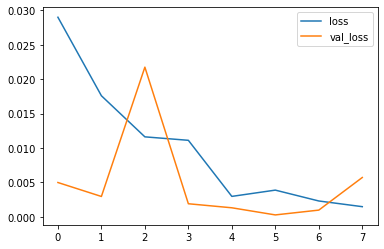

In [18]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [19]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [20]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


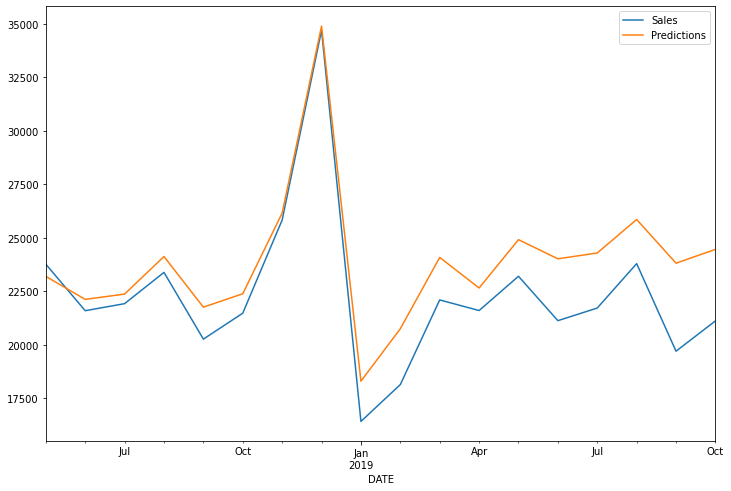

In [21]:
test.plot(figsize=(12,8))

#**Retrain and forecast**

In [22]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [23]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [24]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [25]:
model.fit_generator(generator,epochs=8)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0230
Epoch 2/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0162
Epoch 3/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0080
Epoch 4/8
322/322 [==============================] - 1s 5ms/step - loss: 0.0031
Epoch 5/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0038
Epoch 6/8
322/322 [==============================] - 1s 5ms/step - loss: 0.0015
Epoch 7/8
322/322 [==============================] - 1s 5ms/step - loss: 0.0013
Epoch 8/8
322/322 [==============================] - 1s 5ms/step - loss: 0.0011


In [27]:
forecast = []
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
  current_pred = model.predict(current_batch)[0]
    
  forecast.append(current_pred) 
    
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [28]:
forecast = scaler.inverse_transform(forecast)

In [30]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [31]:
df.tail()

,Sales
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [33]:
forecast_df.head()

,Forecast
2019-11-01,25482.202116
2019-12-01,35939.122376
2020-01-01,16714.560863
2020-02-01,18382.247570
2020-03-01,21566.818008


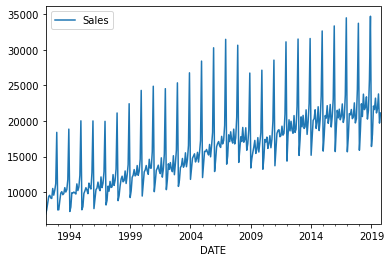

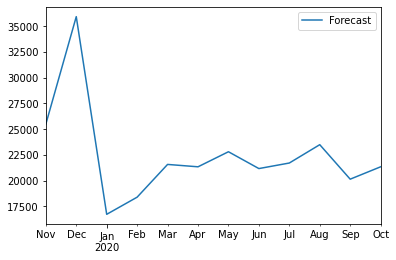

In [34]:
df.plot()
forecast_df.plot()

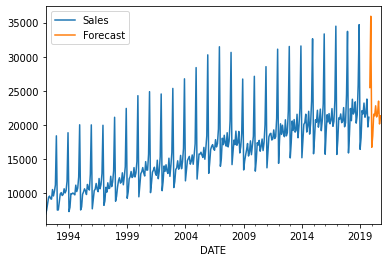

In [35]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

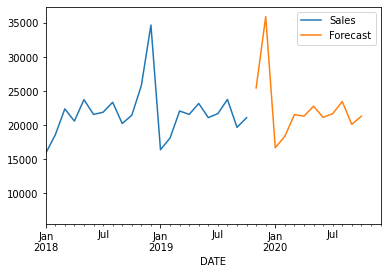

In [36]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')